In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft
from IPython.display import Audio, display
from zvon import *

In [2]:
def show(y):
    x = range(len(y))
    print('min:', np.min(y), ', max:', np.max(y))
    plt.plot(x, y)
    plt.show()

def log10(x):
    return np.log10(x.clip(min=1e-30))

def show_fft(y, max_freq=15000):
    fft_y = 20 * log10(np.abs(fft(y)) / len(y))
    plt.plot(range(len(y)), fft_y)
    plt.xlim(0, max_freq)
    plt.ylim(-120, 0)
    plt.show()

def save_audio(y, filename='test.wav'):
    audio = Audio(y, rate=SR)
    display(audio)
    open(filename, "wb").write(audio.data)

def save_audio_stereo(y, filename='test.wav'):
    left, right = np.array([v[0] for v in y]), np.array([v[1] for v in y])
    save_audio([left, right], filename)

In [3]:
NOTES = {
    'c-': 0,
    'c#': 1,
    'd-': 2,
    'd#': 3,
    'e-': 4,
    'f-': 5,
    'f#': 6,
    'g-': 7,
    'g#': 8,
    'a-': 9,
    'a#': 10,
    'b-': 11
}

def note_freq(note):
    n, o = note[:2].lower(), int(note[2])
    return midi_freq(NOTES[n] + 12 * (o + 2))

def change(stack, params):
    for box_idx, param, val1, val2 in params:
        box = stack[box_idx]
        box.change(box.state, param, val1, val2)

def play_song(channels, song, tick):
    samples = []
    for row in song:
        for chan, params in zip(channels, row):
            if chan.is_on:
                change(chan.stack, params)
        samples += mix_process(channels, len(row), tick, 1)
    return samples

In [4]:
class ADSR:
    __slots__ = ('env', 'attack_t', 'decay_t', 'sustain_level', 'release_t')

def adsr_init(s):
    s.env = Env()
    env_init(s.env, [sec(0.01), sec(0.1), sec(0.3)], 0, [1, 0.5, 0])

def adsr_set_attack(s, t):
    s.env.deltas[0] = sec(t)

def adsr_set_decay(s, t):
    s.env.deltas[1] = sec(t)

def adsr_set_sustain(s, level):
    s.env.levels[1] = level

def adsr_set_release(s, t):
    s.env.deltas[2] = sec(t)

def adsr_note_on(s):
    env_reset(s.env)
    s.env.sustain_pos = 1

def adsr_note_off(s):
    s.env.sustain_pos = -1

def adsr_next(s):
    return env_next(s.env)

In [5]:
class synth_state:
    __slots__ = ('phase', 'adsr', 'freq', 'wave_type')

def synth_init(s):
    s.phase = Phasor()
    phasor_init(s.phase)
    s.adsr = ADSR()
    adsr_init(s.adsr)
    s.freq = 0
    s.wave_type = 0

def synth_change(s, param, val, data):
    if param == 'ZV_NOTE_ON':
        s.freq = val
        adsr_note_on(s.adsr)
    elif param == 'ZV_NOTE_OFF':
        adsr_note_off(s.adsr)
    elif param == 'ZV_WAVE_TYPE':
        s.wave_type = limit(val, 0, 1)

def synth_next(s, l):
    p = phasor_next(s.phase, s.freq)
    if s.wave_type == 0:
        x = square(p, 0.5)
    elif s.wave_type == 1:
        x = saw(p, 0.5)
    return x * adsr_next(s.adsr)

def sfx_synth(s):
    s.change = synth_change
    s.mono = synth_next
    s.state = synth_state()
    s.stereo = None
    synth_init(s.state)

class test_delay_state:
    __slots__ = ('dly',)

def test_delay_init(s):
    s.dly = Delay()
    delay_init(s.dly, sec(0.5), 0.5, 0.5)

def test_delay_change(s, param, val1, val2):
    if param == 'ZV_VOLUME':
        s.dly.level = val1

def test_delay_next(s, l):
    return delay_next(s.dly, l)

def test_delay_box(s):
    s.change = test_delay_change
    s.mono = test_delay_next
    s.state = test_delay_state()
    s.stereo = None
    test_delay_init(s.state)

class box_overdrive_state:
    __slots__ = ('drive', 'vol')

def box_overdrive_init(s):
    s.drive = 1
    s.vol = 1

def box_overdrive_change(s, param, val):
    if param == 'ZV_VOLUME':
        s.vol = val
    elif param == 'ZV_DRIVE':
        s.drive = val

def box_overdrive_mono(s, l):
    return s.vol * overdrive(l, s.drive)

def box_overdrive(s):
    s.change = box_overdrive_change
    s.mono = box_overdrive_mono
    s.state = box_overdrive_state()
    s.stereo = None
    box_overdrive_init(s.state)

In [13]:
mix_init(Channels)
box = chan_push(Channels[0], sfx_synth)
box.change(box.state, ZV_WAVE_TYPE, 0)
chan_push(Channels[0], test_delay_box)
chan_set(Channels[0], True, 1, 0)

def note_on(box_idx, note):
    return (box_idx, 'ZV_NOTE_ON', note_freq(note), 0)

def volume(box_idx, vol):
    return (box_idx, 'ZV_VOLUME', vol, 0)

song = [
    [(note_on(0, 'c-3'), volume(0, 1))],
    [(), ()],
    [(note_on(0, 'g-3'), volume(0, 1))],
    [(), ()],
    [(note_on(0, 'e-3'), volume(0, 1))],
    [(), ()],
    [(note_on(0, 'g-3'), volume(0, 1))],
    [(), ()],
    [(note_on(0, 'c-4'), volume(0, 1))],
    [(), ()],
    [(note_on(0, 'g-3'), volume(0, 1))],
    [(), ()],
    [(note_on(0, 'e-3'), volume(0, 1))],
    [(), ()],
    [(note_on(0, 'g-3'), volume(0, 1))],
    [(), ()]    
]

y = play_song(Channels, song, sec(1/8))

show(y)
save_audio_stereo(y)

NameError: name 'ZV_WAVE_TYPE' is not defined

min: -0.9999999958776719 , max: 0.9999999958776719


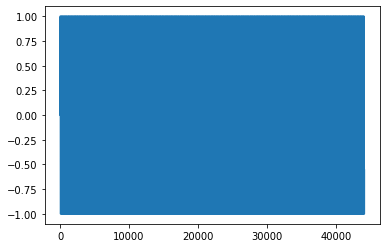

In [7]:
def play(t):
    return overdrive(math.sin(hertz(t, 440)), 10 * 1)

y = [play(t) for t in range(sec(1))]

show(y)
save_audio(y)

C:\Users\peter\AppData\Local\Temp\ipykernel_10092\743244773.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, data = wavfile.read('guitar.wav')


min: -0.81035197 , max: 0.57654375


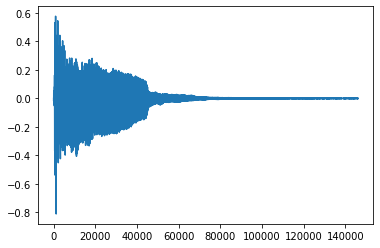

In [8]:
from scipy.io import wavfile

sr, data = wavfile.read('guitar.wav')
left = [l for l, r in data]

show(left)
save_audio(left)


min: -1.0 , max: 1.0


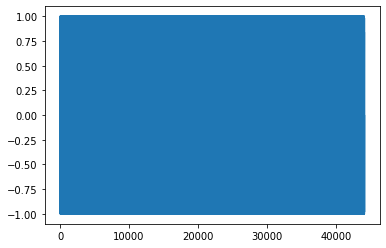

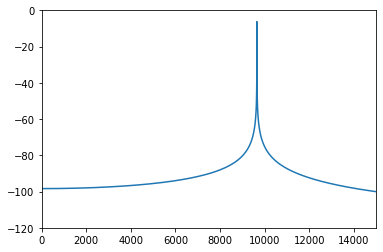

In [9]:
def sin_table(size):
    return [math.sin(2 * PI * t * (1 / size)) for t in range(size)]

def sampler(table, freq, sample_freq):
    phase = 0
    step = freq / sample_freq
    #step = freq / SR * len(table)
    while True:
        p = int(phase)
        x1 = table[p]
        x2 = table[(p + 1) % len(table)]
        yield lerp(x1, x2, phase - p)
        phase = (phase + step) % len(table)

tab = sin_table(256)
g = sampler(tab, 800, 4)
y = [next(g) for _ in range(sec(1))]

show(y)
show_fft(y)
save_audio(y)